### Acoustic Simulation

In [1]:
%matplotlib inline

In [1]:
# EXPORT
import os, sys
from time import time, sleep
import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.nn.functional as F
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.animation as manimati
from matplotlib import animation, rc
from IPython.display import HTML

### Simulation parameters

In [68]:
grid_size = 100
nt = 200 # num time_steps
# CFL: dt <= C dx  
C = 1.
dt = .1
dx = .2
num_sources = 128 # max 360
max_u0 = 1. # maximum starting value
t = dt*np.arange(nt)
t[-1]

19.900000000000002

### Initial conditions for Wave Equation: Source locations and amplitudes

##### Note that each source has a frequency:
\begin{equation*}
f \in \mathcal{N}(f_0,d_{Hz})\
\end{equation*}

In [60]:
# EXPORT
def generate_input(num_sources=128,max_u0=1.,grid_size=100,f0=2,d_Hz=.1,nt=200,dt=.1,insync=False):
    # len(v)*len(w) = 360
    v = np.arange(5,grid_size-5,2)
    w = np.arange(5,20,2)
    x,y = np.meshgrid(v,w)
    t = dt*np.arange(nt)
    potential_sources = np.array(list(zip(x.flatten(),y.flatten())))
    inds = np.random.choice(len(potential_sources),size=num_sources,replace=False)
    f = torch.zeros((nt,grid_size,grid_size),requires_grad=True)
    source_locs = []
    freqs = []
    for idx in inds:
        i,j = potential_sources[idx]
        source_locs.append(potential_sources[i])
        f0_samp = d_Hz*np.random.randn() + f0
        freqs.append(f0_samp)
        phase = 0
        if not insync:
            phase = 2*np.pi*np.random.rand()
        f[:,j,i] = torch.tensor(max_u0*np.sin(2*np.pi*(f0_samp*t)+phase))
        #plt.plot(t,f[:,j,i].detach().numpy())
    prev_u = torch.zeros((grid_size,grid_size),requires_grad=True)
    u, prev_u = Variable(f, requires_grad=True), Variable(prev_u, requires_grad=True)
    return u, prev_u, source_locs, freqs

In [4]:
# EXPORT
def plot_image(f, title='wave amplitude'):
    # plt.ion()
    u_mx = f.max()
    fig = plt.figure()
    ax = fig.add_subplot(111)
    plt.title(title)
    cmap = plt.cm.ocean
    img = ax.imshow(f.data, cmap=cmap, vmin=-u_mx, vmax=u_mx)

    fig.colorbar(img, orientation='vertical')
    plt.show()
    return img, fig

### Potential Source Locs

In [5]:
u, up, s, f = generate_input(num_sources=360)

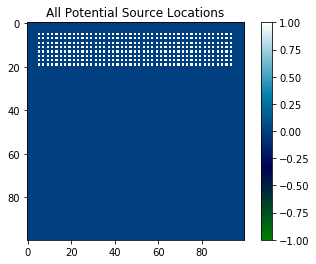

In [6]:
I0 = np.sign(np.abs(u[0].detach().numpy()))
img, fig = plot_image(I0, 'All Potential Source Locations')

In [7]:
I0.min()

0.0

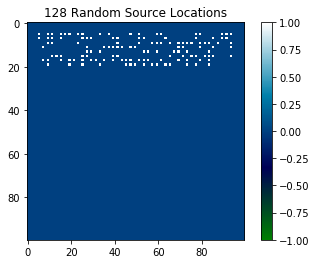

In [8]:
ns = num_sources
u, prev_u, s, f = generate_input(num_sources=ns,nt=nt)
I0 = np.sign(np.abs(u[0].detach().numpy()))
img, fig = plot_image(I0, '{:d} Random Source Locations'.format(ns))

### Laplacian

In [9]:
# EXPORT
def Laplacian(u):
    u = u.unsqueeze(0).unsqueeze(0)
    L = np.array([[.5, 1, .5], [1, -6., 1], [.5, 1, .5]], 'float32')
    pad = (L.shape[0]-1)//2
    conv = nn.Conv2d(1, 1, L.shape[0], 1, bias=False, padding=(pad, pad))
    conv.weight.data = torch.tensor(L).unsqueeze(0).unsqueeze(0)
    return conv(u).squeeze(0).squeeze(0)

### Wave equation

In [10]:
# EXPORT
def run_wave_forward(f,prev_u,nt,dt,dx,c):
    u = f[0,:,:]
    soln = [u]
    DT_DX_SQ = c*(dt/dx)**2
    for i in range(nt-1):
        next_u = DT_DX_SQ*Laplacian(u) + 2*u - prev_u + dt*f[i,:,:]
        prev_u = u
        u = next_u
        soln.append(u)
    soln = np.array([i.detach().numpy() for i in soln])
    return soln

In [ ]:
# EXPORT
def wave_steady_state(f,prev_u,nt,dt,dx,c,num_keep):
    u = f[0,:,:]
    soln = []
    DT_DX_SQ = c*(dt/dx)**2
    for i in range(nt-1):
        next_u = DT_DX_SQ*Laplacian(u) + 2*u - prev_u + dt*f[i,:,:]
        prev_u = u
        u = next_u
        if i >= nt - num_keep -1 :
            soln.append(u)
    soln = np.array([i.detach().numpy() for i in soln])
    return soln


In [69]:
s = run_wave_forward(u,prev_u,nt,dt,dx,C)
print(s.shape)

(200, 100, 100)


### Video Output of Solution

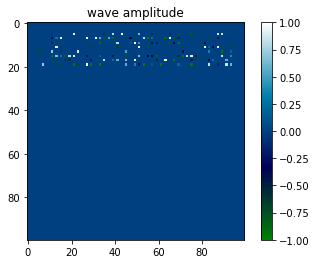

In [19]:
# First set up the figure, the axis, and the plot element we want to animate
ti = 0
title = 'wave amplitude'
u_mx = np.max(np.abs(s))
fig = plt.figure()
ax = fig.add_subplot(111)
plt.title(title)
cmap = plt.cm.ocean
img = ax.imshow(s[0], cmap=cmap, vmin=-u_mx, vmax=u_mx)
fig.colorbar(img, orientation='vertical')
#plt.show()

# initialization function: plot the background of each frame
def init():
    img = ax.imshow(s[0], cmap=cmap, vmin=-u_mx, vmax=u_mx)
    return (fig,)

# animation function. This is called sequentially
def animate(i):
    img = ax.imshow(s[i], cmap=cmap, vmin=-u_mx, vmax=u_mx)
    return (fig,)

# call the animator. blit=True means only re-draw the parts that have changed.
anim = animation.FuncAnimation(fig, animate, init_func=init,
                               frames=len(s), interval=20, blit=True)


In [20]:
HTML(anim.to_html5_video())

In [15]:
# animation function. This is called sequentially
def animate(i):
    img = ax.imshow(s[i], cmap=cmap, vmin=-u_mx, vmax=u_mx)
    return (fig,)

In [132]:
anim.save('wave_equation.mp4', fps=30, extra_args=['-vcodec', 'libx264'])

In [66]:
# EXPORT
def create_movie(s,outfile='wave_equation.mp4'):
    ti = 0
    title = 'wave amplitude'
    u_mx = np.max(np.abs(s))
    fig = plt.figure()
    ax = fig.add_subplot(111)
    plt.title(title)
    cmap = plt.cm.ocean
    img = ax.imshow(s[0], cmap=cmap, vmin=-u_mx, vmax=u_mx)
    fig.colorbar(img, orientation='vertical')
    #plt.show()

    # initialization function: plot the background of each frame
    def init():
        img = ax.imshow(s[0], cmap=cmap, vmin=-u_mx, vmax=u_mx)
        return (fig,)

    # animation function. This is called sequentially
    def animate(i):
        img = ax.imshow(s[i], cmap=cmap, vmin=-u_mx, vmax=u_mx)
        return (fig,)

    # call the animator. blit=True means only re-draw the parts that have changed.
    anim = animation.FuncAnimation(fig, animate, init_func=init,
                                   frames=len(s), interval=20, blit=True)
    anim.save(outfile, fps=30, extra_args=['-vcodec', 'libx264'])

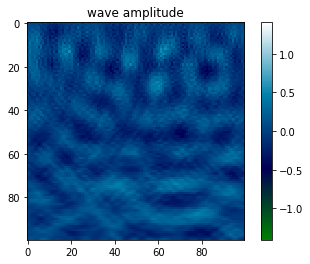

In [71]:
create_movie(s,outfile='test.mp4')

### Get the Steady State Signal

### Change C to Speed of Sound in Air and the frequency
\begin{equation*}\label{eq:}
C = 343 \frac{m}{s}
\end{equation*}
\begin{equation*}
f \in \mathcal{N}(f_0,\Delta{Hz})\
\end{equation*}
Important CFL condition: https://en.wikipedia.org/wiki/Courant%E2%80%93Friedrichs%E2%80%93Lewy_condition

In [54]:
c = 343 # m/s
f0 = 1002 # Hz
d_Hz = .1 # Hz
fs = 10*np.round(2.1*f0)
dt = 1/fs # we have to sample at twice f0 
nt = 1001 #10*60*fs # 10 minutes of data
dx = .2
t =  dt*np.arange(nt)
print(t[-1])

0.04752851711026616


(1000, 100, 100)
torch.Size([1001, 100, 100])


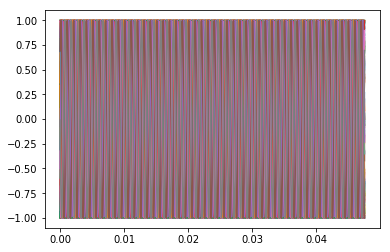

In [61]:
num_sources = 128
u, prev_u, source_locs, f = generate_input(num_sources=num_sources,nt=nt,f0=f0,d_Hz=d_Hz,dt=dt)
s = wave_forward_steady_state(u,prev_u,nt,dt,dx,c=c,num_keep=1000)
print(s.shape)
print(u.shape)

In [50]:
source_locs[:10]

[array([21,  7]),
 array([49,  7]),
 array([71,  5]),
 array([87,  5]),
 array([81,  7]),
 array([73,  7]),
 array([93,  7]),
 array([31,  5]),
 array([67,  5]),
 array([61,  7])]

(1001,)


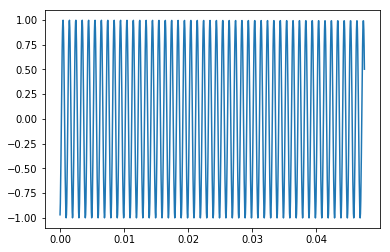

In [62]:
idx = 10
i, j = source_locs[idx]
s0 = u[:,j,i].detach().numpy()
print(s0.shape)
plt.plot(t,s0)

In [63]:
from numpy.fft import rfft

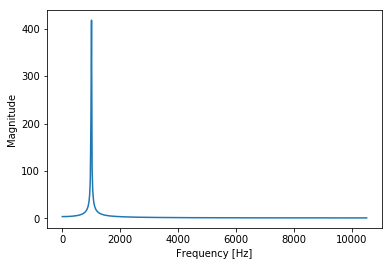

In [65]:
nfft = len(s0)
#outfile = '{}_synthetic_FFT.png'.format(pngFn)
S = rfft(s0, nfft)
freqs = np.linspace(0,fs/2,len(S))
plt.plot(freqs,np.abs(S))
plt.xlabel('Frequency [Hz]')
plt.ylabel('Magnitude')
plt.show()

In [ ]:
s_flat = []
for i in range(grid_size):
    for j in range(grid_size):
        s_flat.append((np.squeeze(s[:,i,j]),num_sources))

In [42]:
c = 343 # m/s
f0 = 1002 # Hz
d_Hz = .1 # Hz
dt = 1/(2.1*f0)# we have to sample at twice f0 
print(dt/dx)
nt = 1000 #10*60*fs # 10 minutes of data
t = dt*np.arange(nt)
print(t[-1])

0.0023761999809904
0.4747647562018819


In [43]:
u, prev_u, source_locs, f = generate_input(num_sources=num_sources,nt=nt,f0=f0,d_Hz=d_Hz)

In [44]:
s = run_wave_forward(u,prev_u,nt,dt,dx,c=c)

In [45]:
u_numpy = u.detach().numpy()
u_numpy.shape

(1000, 100, 100)

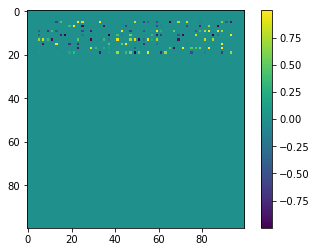

In [46]:
A = np.squeeze(u_numpy[0,:,:])
plt.imshow(A); plt.colorbar()

In [47]:
source_locs

[array([33,  7]),
 array([87,  5]),
 array([73,  7]),
 array([37,  7]),
 array([27,  5]),
 array([21,  7]),
 array([93,  7]),
 array([33,  7]),
 array([69,  7]),
 array([49,  7]),
 array([41,  7]),
 array([71,  5]),
 array([85,  7]),
 array([89,  7]),
 array([47,  5]),
 array([55,  5]),
 array([29,  7]),
 array([33,  7]),
 array([75,  5]),
 array([25,  7]),
 array([11,  9]),
 array([77,  7]),
 array([27,  5]),
 array([91,  5]),
 array([61,  7]),
 array([31,  5]),
 array([11,  9]),
 array([39,  5]),
 array([31,  5]),
 array([11,  9]),
 array([93,  7]),
 array([19,  5]),
 array([13,  7]),
 array([71,  5]),
 array([37,  7]),
 array([51,  5]),
 array([61,  7]),
 array([31,  5]),
 array([73,  7]),
 array([25,  7]),
 array([15,  5]),
 array([89,  7]),
 array([29,  7]),
 array([85,  7]),
 array([55,  5]),
 array([57,  7]),
 array([51,  5]),
 array([5, 7]),
 array([69,  7]),
 array([87,  5]),
 array([45,  7]),
 array([29,  7]),
 array([51,  5]),
 array([79,  5]),
 array([5, 7]),
 array([9, 7])

In [48]:
s.shape

(1000, 100, 100)

In [53]:
sig = s[:,source_locs[0][0], source_locs[0][1]]
print(sig.max())
print(sig.min())
print(sig.shape)

1.5338882
-2.292323
(1000,)


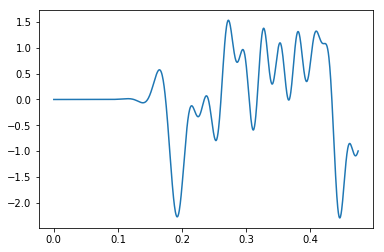

In [54]:
plt.plot(t,sig)

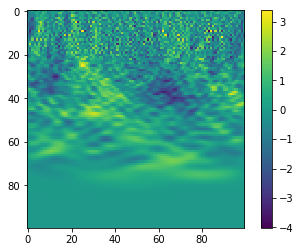

In [55]:
plt.imshow(s[-1]); plt.colorbar()

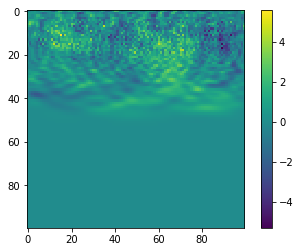

In [56]:
plt.imshow(s[nt//2]); plt.colorbar()

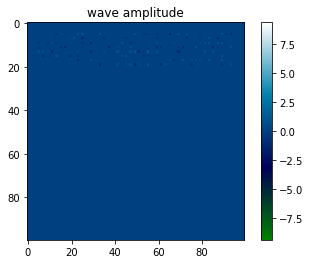

In [57]:
# First set up the figure, the axis, and the plot element we want to animate
ti = 0
title = 'wave amplitude'
u_mx = np.max(np.abs(s))
fig = plt.figure()
ax = fig.add_subplot(111)
plt.title(title)
cmap = plt.cm.ocean
img = ax.imshow(s[0], cmap=cmap, vmin=-u_mx, vmax=u_mx)
fig.colorbar(img, orientation='vertical')
#plt.show()

# initialization function: plot the background of each frame
def init():
    img = ax.imshow(s[0], cmap=cmap, vmin=-u_mx, vmax=u_mx)
    return (fig,)

# animation function. This is called sequentially
def animate(i):
    img = ax.imshow(s[i], cmap=cmap, vmin=-u_mx, vmax=u_mx)
    return (fig,)

# call the animator. blit=True means only re-draw the parts that have changed.
anim = animation.FuncAnimation(fig, animate, init_func=init,
                               frames=len(s), interval=20, blit=True)

In [ ]:
HTML(anim.to_html5_video())

In [33]:
source_locs[0]

array([85,  7])

### Plot Microphone Signal

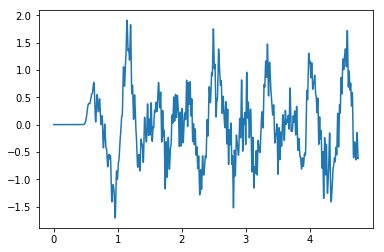

In [35]:
i,j = np.random.randint(0,grid_size,(2,)
sig = np.squeeze(s[:,i,j])
plt.plot(t,sig)

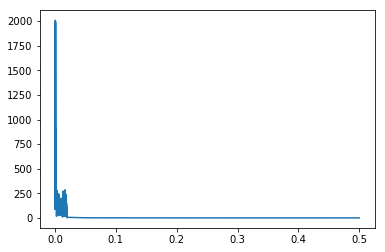

In [42]:
S = np.fft.rfft(sig)
freq = np.fft.rfftfreq(t.shape[-1])
plt.plot(freq[:len(S)], np.abs(S))
plt.show()

In [41]:
t.shape[-1]

10000

### Generate Data

In [14]:
# EXPORT
def generate_wave_data(num_sources=10,max_u0=1,grid_size=100,nt=200):
    u, u_prev = get_initial_conditions(num_sources,max_u0,grid_size)
    # CFL: dt <= C dx  
    dt = .01
    dx = .2
    soln = run_wave_forward(u, u_prev, dt, dx, nt)
    return soln

In [15]:
A = generate_wave_data(num_sources=12,max_u0=1.,grid_size=100,nt=200)
print(A[0].shape)

torch.Size([100, 100])


### Dataset and DataLoader

In [16]:
# EXPORT
from torch.utils.data import Dataset, DataLoader
class WaveDataset(Dataset):
    def __init__(self, n_sims=100,transform=None):

        self.sim_params = []
        data = []
        for k in range(n_sims):
            d = dict()
            d['num_sources'] = 1 #np.random.randint(5,16)
            #self.sim_params.append(d)
            X = generate_wave_data(**d)
            X = [xi.detach().numpy() for xi in X]
            data.append(X)
        data = [item for sublist in data for item in sublist]
        # collects two frames as input and predicts the third 
        # frame as output. This is an inefficient way to 
        # store data. 
        # TODO: Store data smarter
        stacked_frames = []
        for idx,d in enumerate(data[:-3]):
            X = np.stack((d,data[idx+1]))
            y = data[idx+2]
            stacked_frames.append((X,y))
            
        self.data = stacked_frames
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        X,y = self.data[idx]
        if self.transform:
            X = self.transform(X)
        return X,y

In [17]:
WD = WaveDataset(n_sims=10)
X,y = WD[5]
print(len(X))
print(y.shape)

2
(100, 100)


In [18]:
WD_loader = DataLoader(WD, batch_size=8,shuffle=True)
X,y = next(iter(WD_loader))
print(len(X))
print(X[0].shape)
print(y.shape)

8
torch.Size([2, 100, 100])
torch.Size([8, 100, 100])


### Build a model

In [19]:
class ConvModel(nn.Module):
    def __init__(self,latent=10):
        super(ConvModel,self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(2,8,kernel_size=3,padding=1),
            nn.ELU(),
            nn.Conv2d(8,16,kernel_size=3,padding=1),
            nn.ELU(),
            nn.Conv2d(16,32,kernel_size=3,padding=1),
            nn.ELU(),
            nn.Conv2d(32,1,kernel_size=3,padding=1)
        )
    def forward(self, x):   
        x = self.conv(x)
        x = torch.squeeze(x)
        return x

In [20]:
model = ConvModel()

In [21]:
pred = model(X)
print(pred.shape)

torch.Size([8, 100, 100])


### Parameters for training

In [22]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.to(device)
num_epochs = 2
batch_size = 8
lr = .001
print_every = 100
import torch.optim as optim
from torch.optim import lr_scheduler
opt = torch.optim.Adam(model.parameters(), lr=lr)
#scheduler = lr_scheduler.ReduceLROnPlateau(opt,patience=3) 
steps = int(num_epochs*len(WD.data)//batch_size)
scheduler = optim.lr_scheduler.CosineAnnealingLR(opt, steps)
# mse loss
loss = nn.MSELoss()

### Train the model

In [23]:
model.train()
for epoch in range(num_epochs):
    print('epoch {:d}'.format(epoch))
    for idx,batch in enumerate(WD_loader,0):
        X,y = batch
        X.to(device)
        y.to(device)
        opt.zero_grad()
        pred = model(X)
        L = loss(pred,y)
        L.backward()
        opt.step()
        scheduler.step()
        if idx % print_every == 0:
            print('step {:d}'.format(idx))
            print('loss {:.4e}'.format(L.item()))
            print('lr: {:4e}'.format(scheduler.get_lr()[0]))
            print('_'*80)

epoch 0
step 0
loss 1.0827e-02
lr: 9.999901e-04
________________________________________________________________________________
step 100
loss 2.9546e-04
lr: 9.022766e-04
________________________________________________________________________________
step 200
loss 1.9031e-04
lr: 6.503112e-04
________________________________________________________________________________
epoch 1
step 0
loss 3.0049e-04
lr: 4.952782e-04
________________________________________________________________________________
step 100
loss 2.4549e-04
lr: 2.017949e-04
________________________________________________________________________________
step 200
loss 1.5727e-04
lr: 2.265758e-05
________________________________________________________________________________


### Save the model

### Test the model

In [24]:
model.eval()
# build a test dataset
WD_test = WaveDataset(n_sims=10)
WD_test_loader = DataLoader(WD_test, batch_size=8,shuffle=False)
loss_by_batch = []
for X,y in WD_test_loader:
    X.to(device)
    y.to(device)
    pred = model(X)
    L = loss(pred,y)
    loss_by_batch.append(L.item())

print('avg_loss: {:.4e}'.format(np.mean(loss_by_batch)))

avg_loss: 2.1623e-04


### Can the neural network be used as a surrogate?

In [28]:
sim = generate_wave_data(num_sources=1,max_u0=1.,grid_size=100,nt=200)

In [29]:
s = np.array([i.detach().numpy() for i in sim])
# call the animator. blit=True means only re-draw the parts that have changed.
anim = animation.FuncAnimation(fig, animate, init_func=init,
                               frames=len(s), interval=20, blit=True)

In [30]:
HTML(anim.to_html5_video())

In [44]:
surrogate = [sim[0]]
input0 = torch.stack((u_prev, sim[0]))
input0.unsqueeze_(0)
out1 = model(input0)
#print(out1.detach().numpy())
surrogate.append(out1)

In [45]:
for idx in range(200-2):
    X = torch.stack(surrogate[idx:idx+2])
    X.unsqueeze_(0)
    y = model(X)
    surrogate.append(y)

In [46]:
len(surrogate)

200

In [47]:
s = np.array([i.detach().numpy() for i in surrogate])
# call the animator. blit=True means only re-draw the parts that have changed.
surr_anim = animation.FuncAnimation(fig, animate, init_func=init,
                               frames=len(s), interval=20, blit=True)

In [48]:
HTML(surr_anim.to_html5_video())

In [51]:
s.max()
s.min()

-2.3077896